In [1]:
### Import the required libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt
import cmocean

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow.keras as keras
from keras import metrics
import innvestigate

import os
from os.path import join
import sys

import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset
import ecco_v4_py as ecco

import random

# See if GPUs are available
from keras import backend as K
if bool(K._get_available_gpus()):
    print("Running on GPU")
else:
    print("Running on CPU")

# Append to sys.path the absolute path to src/XAIRT
path_list = os.path.abspath('').split('/')
path_src_XAIRT = ''
for link in path_list[:-1]:
    path_src_XAIRT = path_src_XAIRT+link+'/'
sys.path.append(path_src_XAIRT+'/src')

# Now import module XAIRT
from XAIRT import *

### https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed ###
### https://keras.io/examples/keras_recipes/reproducibility_recipes/ ###
SEED = 42
keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

tf.compat.v1.disable_eager_execution()

2024-03-01 12:54:14.603706: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-01 12:54:16.082190: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 459 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-03-01 12:54:16.084773: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 37648 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-03-01 12:54:16.086799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/repli

Running on GPU


In [2]:
### Sverdrup 
# mainDir_r4  = '/scratch2/pillarh/eccov4r4'
# mainDir_r5  = '/scratch2/pillarh/eccov4r5'
# gridDir  = mainDir_r4 + '/GRID'
# thetaDir = mainDir_r5 + '/V4r5/diags_daily/SST_day_mean'
# thetaDir_ext = mainDir_r5 + '/V4r5_ext_2020_2023_Jun/diags_daily/SST_day_mean'

## LS6
mainDir_r4 = '/work/07665/shrey911/ls6/LRP_eccov4r4_data'
mainDir_r5 = '/work/07665/shrey911/ls6/LRP_eccov4r5_data'
gridDir  = mainDir_r5 + '/GRID'
thetaDir = mainDir_r5 + '/SST_day_mean'
thetaDir_ext = mainDir_r5 + '/SST_day_mean_ext_2020_2023_Jun'

# For Sverdrup
# ds_r4 = xr.open_dataset(f'/scratch2/shreyas/LRP_eccov4r4_data/thetaSurfECCOv4r4.nc')
# For LS6
ds_r4 = xr.open_dataset(mainDir_r4 + '/thetaSurfECCOv4r4.nc')

# SSH has to be kept because someone used the SSH metadata for SST, 
# It's not a bug in this code but a hack to handle an existing bug.
temp = xmitgcm.open_mdsdataset(data_dir = thetaDir,
                             grid_dir = gridDir,
                             extra_variables = dict(SSH = dict(dims=['k','j','i'],
                                                               attrs = dict(standard_name="SST",
                                                                            long_name="Sea Surface Temperature",
                                                                            units="degC"))))
temp["SST"] = temp["SSH"]
temp = temp.drop(["SSH"])
    
temp_ext = xmitgcm.open_mdsdataset(data_dir = thetaDir_ext,
                                 grid_dir = gridDir,
                                 extra_variables = dict(SST = dict(dims=['k','j','i'],
                                                                   attrs = dict(standard_name="SST",
                                                                                long_name="Sea Surface Temperature",
                                                                                units="degC"))))

ds_r5 = xr.concat([temp, temp_ext], "time")

In [3]:
ds_SST = xr.open_dataset(mainDir_r5+'/SST_all.nc')
SST = ds_SST['SST'].data

In [4]:
hFacC = ecco.read_llc_to_tiles(gridDir, 'hFacC.data')
hFacC_mask = hFacC > 0
hFacC_mask = hFacC_mask.astype(float)

XC = ds_r4['XC'].data
YC = ds_r4['YC'].data

latMask = YC > -20.0
latMask = latMask.astype(float)

maskFinal = hFacC_mask * latMask
NaNmaskFinal = np.copy(maskFinal)
NaNmaskFinal[NaNmaskFinal == 0] = np.nan

da_XC = xr.DataArray(
    data=ds_r4['XC'].data,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="XC"),
)

da_YC = xr.DataArray(
    data=ds_r4['YC'].data,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="YC"),
)

da_hFacC_mask = xr.DataArray(
    data=hFacC_mask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="hFacC mask 2D 1 if > 0, else 0"),
)

da_latMask = xr.DataArray(
    data=latMask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="Latitude Mask 1 if > -20, else 0"),
)

da_maskFinal = xr.DataArray(
    data=maskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="Mask 2D 1 if > 0, else 0"),
)

da_NaNmaskFinal = xr.DataArray(
    data=NaNmaskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="Mask 2D True if > 0, else NaN"),
)

wetpoints = np.nonzero(maskFinal.data)
da_wetpoints = xr.DataArray(
    data=np.asarray(wetpoints),
    dims=["wetpoints_dim", "num_wetpoints"],
    coords=dict(
        wetpoints_dim = np.arange(np.asarray(wetpoints).shape[0], dtype = int),
        num_wetpoints = np.arange(np.asarray(wetpoints).shape[1], dtype = int),
    ),
    attrs=dict(description="indices of wetpoints in the order (tile, j, i) in the three rows"),
)

da_SST = xr.DataArray(
    data=SST,
    dims=["time", "tile", "j", "i"],
    coords=dict(
        time = ds_r5['time'].data[:SST.shape[0]],
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="SST field in llc format"),
)

ds = xr.Dataset()
ds = ds.assign(XC           = da_XC,
               YC           = da_YC,
               hFacC_mask   = da_hFacC_mask,
               latMask      = da_latMask,
               maskFinal    = da_maskFinal,
               NaNmaskFinal = da_NaNmaskFinal,
               wetpoints    = da_wetpoints,
               SST          = da_SST)

load_binary_array: loading file /work/07665/shrey911/ls6/LRP_eccov4r5_data/GRID/hFacC.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


In [5]:
def anomalize(field):
    
    leap_yr_offsets_jan_feb   = [0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8]
    leap_yr_offsets_after_feb = [1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8]

    if len(field.shape) > 1:
        seasonal_trend = np.zeros((366, field.shape[1]))
    else:
        seasonal_trend = np.zeros((366,))

    #### Calculate seasonal trend
    
    # Jan 1 - Feb 28
    for d in range(59):
        for year in range(31):
            seasonal_trend[d] += field[d+365*year+leap_yr_offsets_jan_feb[year]]
    seasonal_trend[:59] = seasonal_trend[:59] / 31.0
    
    # Feb 29 starting 1996, so year 2 in 0-indefielding
    n = 0
    for year in range(0,31,4):
        seasonal_trend[59] += field[365*year+n+59]
        n = n+1
    seasonal_trend[59] = seasonal_trend[59] / 8.0
            
    # Mar 1 - Dec 31
    for d in range(60,366):
        for year in range(31):
            seasonal_trend[d] += field[d-1+365*year+leap_yr_offsets_after_feb[year]]
    seasonal_trend[60:] = seasonal_trend[60:] / 31.0
    
    #### Deseason data
    
    # Jan 1 - Feb 28
    for d in range(59):
        for year in range(31):
            field[d+365*year+leap_yr_offsets_jan_feb[year]] = field[d+365*year+leap_yr_offsets_jan_feb[year]] \
                                                        - seasonal_trend[d]
    
    # Feb 29 starting 1996, so year 2 in 0-indexing
    n = 0
    for year in range(0,31,4):
        field[365*year+n+59] = field[365*year+n+59] - seasonal_trend[59]
        n = n+1
            
    # Mar 1 - Dec 31
    for d in range(60,366):
        for year in range(31):
            field[d-1+365*year+leap_yr_offsets_after_feb[year]] = field[d-1+365*year+leap_yr_offsets_after_feb[year]] \
                                                            - seasonal_trend[d]

    scipy.signal.detrend(field, axis=0, type='linear', bp=0, overwrite_data=True)
    field = field - np.mean(field, axis = 0)

    return field

In [6]:
X = ds['SST'].data[:,wetpoints[0],wetpoints[1],wetpoints[2]].copy()
X = anomalize(X)
X_full = X.copy()
X = X[30:-30]

y = ds['SST'].isel(tile = 10, j = 1, i = 43).data.copy()
y = anomalize(y)
# https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
y = np.convolve(y, np.ones(61)/61, mode='valid')
oneHotCost = np.zeros((y.shape[0], 2), dtype = int)
oneHotCost[:,0] = y >= 0.0
oneHotCost[:,1] = y <  0.0

In [7]:
da_X = xr.DataArray(
    data=X,
    dims=["time_allData", "num_wetpoints"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
        num_wetpoints = ds['num_wetpoints'].data,
    ),
    attrs=dict(description="All data as matrix X; deseasoned, delinearized and mean removed."),
)

da_y = xr.DataArray(
    data=y,
    dims=["time_allData"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
    ),
    attrs=dict(description="All cost function y; deseasoned, delinearized and mean removed."),
)

da_X_full = xr.DataArray(
    data=X_full,
    dims=["time", "num_wetpoints"],
    coords=dict(
        time          = ds['time'],
        num_wetpoints = ds['num_wetpoints'].data,
    ),
    attrs=dict(description="All data without accounting for conv filter as matrix X_full; deseasoned, delinearized and mean removed."),
)

da_oneHotCost = xr.DataArray(
    data=oneHotCost,
    dims=["time_allData", "NN_output_dim"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
        NN_output_dim = np.array([0,1]),
    ),
    attrs=dict(description="All cost function as one-hot vector."),
)

ds = ds.assign(X          = da_X,
               y          = da_y,
               X_full     = da_X_full,
               oneHotCost = da_oneHotCost)

## Correlation maps

In [8]:
lagStepsList = [-60,-30,0,30,60,90,120,150,180]

subplot_idx = 1
plt.rcParams["figure.figsize"] = (20,10)

corr_dict = {}

for lagSteps in lagStepsList:
    
    corr_dict[lagSteps] = np.zeros((13, 90, 90))
    
    if lagSteps > 0:
        corr_dict[lagSteps][wetpoints[0], wetpoints[1], wetpoints[2]] = np.copy(correlation(X[:-lagSteps],y[lagSteps:]))
    elif lagSteps == 0:
        corr_dict[lagSteps][wetpoints[0], wetpoints[1], wetpoints[2]] = np.copy(correlation(X,y))
    else:
        corr_dict[lagSteps][wetpoints[0], wetpoints[1], wetpoints[2]] = np.copy(correlation(X[-lagSteps:],y[:lagSteps]))

## Plots by time lag

In [9]:
ds_LRP_A1B0_small = xr.open_dataset('LRP_output_forHelen/LRP_A1B0_small.nc')
ds_LRP_A1B0 = xr.open_dataset('LRP_output_forHelen/LRP_A1B0.nc')
ds_OI_pos_small = xr.open_dataset('LRP_output_forHelen/OI_small_v4r5_pos.nc')
ds_OI_pos = xr.open_dataset('LRP_output_forHelen/OI_v4r5_pos.nc')
ds_OI_neg_small = xr.open_dataset('LRP_output_forHelen/OI_small_v4r5_neg.nc')
ds_OI_neg = xr.open_dataset('LRP_output_forHelen/OI_v4r5_neg.nc')

Text(0.5, 1.0, 'OI negative small lag 0 days')

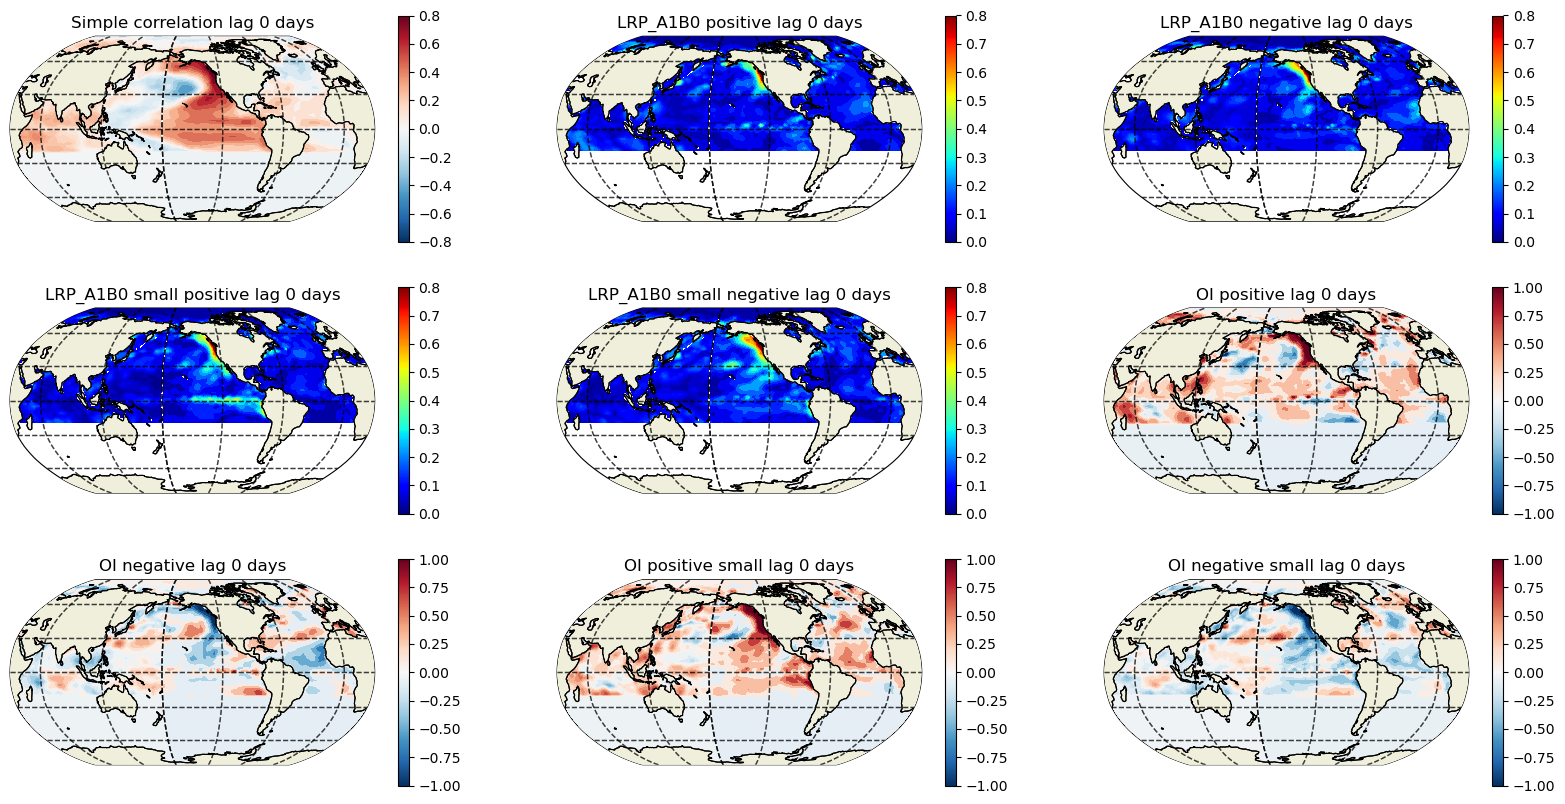

In [10]:
plt.rcParams["figure.figsize"] = (20,10)

lag = 0

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], corr_dict[lag],
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', 
                              cmin = -0.8, cmax = 0.8, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,1]);
P[1].set_title(f"Simple correlation lag {lag} days")

field = ds_LRP_A1B0[f'lrp_{lag}_a1b0_b_pos_all'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', 
                              cmin = 0, cmax = 0.8, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,2]);
P[1].set_title(f"LRP_A1B0 positive lag {lag} days")

field = ds_LRP_A1B0[f'lrp_{lag}_a1b0_b_neg_all'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', 
                              cmin = 0, cmax = 0.8, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,3]);
P[1].set_title(f"LRP_A1B0 negative lag {lag} days")

field = ds_LRP_A1B0_small[f'lrp_{lag}_a1b0_b_pos_all'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', 
                              cmin = 0, cmax = 0.8, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,4]);
P[1].set_title(f"LRP_A1B0 small positive lag {lag} days")

field = ds_LRP_A1B0_small[f'lrp_{lag}_a1b0_b_neg_all'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', 
                              cmin = 0, cmax = 0.8, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,5]);
P[1].set_title(f"LRP_A1B0 small negative lag {lag} days")

field = ds_OI_pos[f'OI_{lag}'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', 
                              cmin = -1, cmax = 1, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,6]);
P[1].set_title(f"OI positive lag {lag} days")

field = ds_OI_neg[f'OI_{lag}'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', 
                              cmin = -1, cmax = 1, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,7]);
P[1].set_title(f"OI negative lag {lag} days")

field = ds_OI_pos_small[f'OI_{lag}'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', 
                              cmin = -1, cmax = 1, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,8]);
P[1].set_title(f"OI positive small lag {lag} days")

field = ds_OI_neg_small[f'OI_{lag}'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', 
                              cmin = -1, cmax = 1, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,9]);
P[1].set_title(f"OI negative small lag {lag} days")

Text(0.5, 1.0, 'OI negative small lag 60 days')

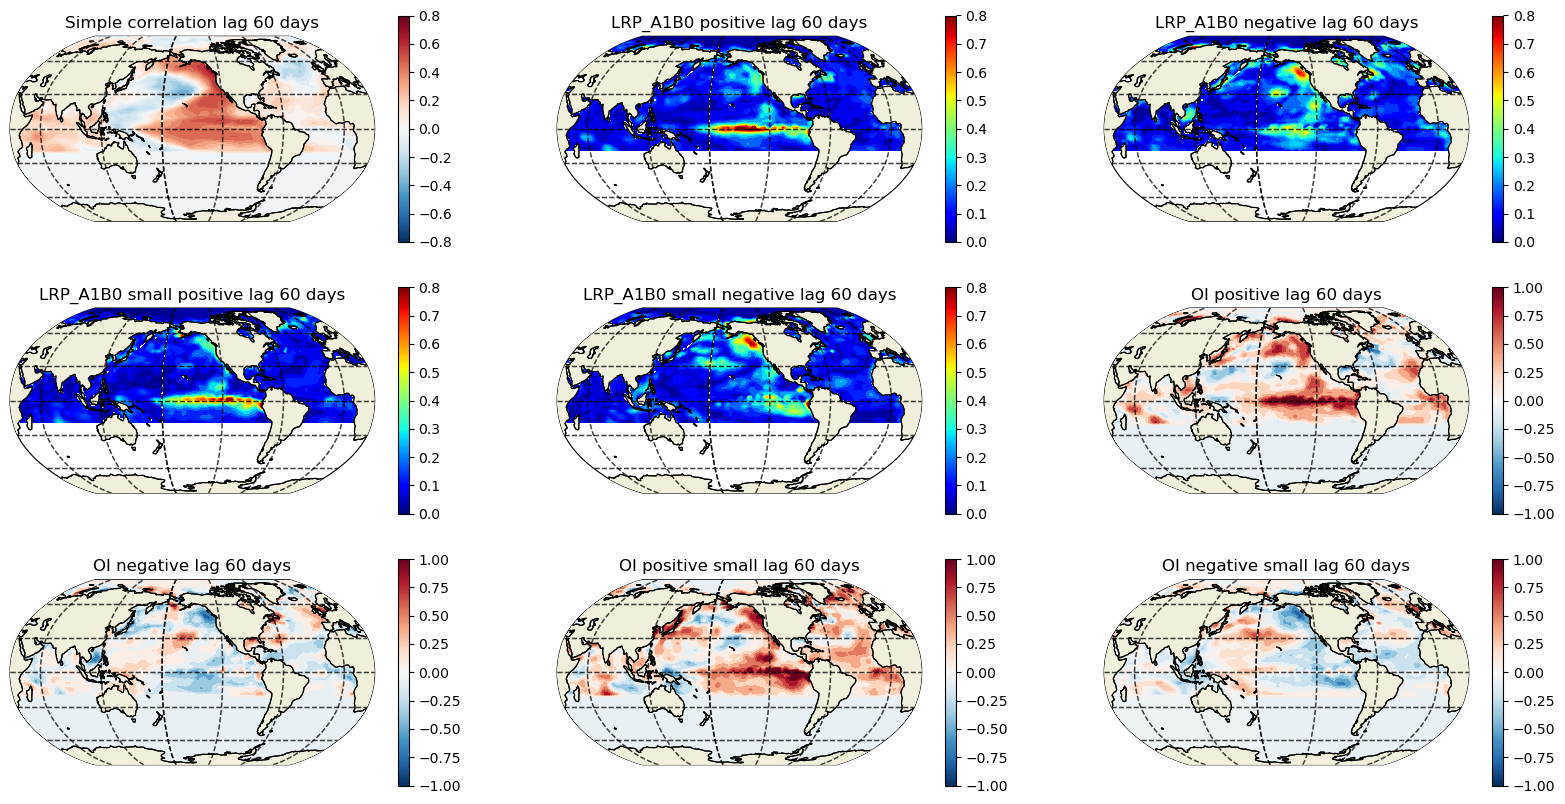

In [11]:
plt.rcParams["figure.figsize"] = (20,10)

lag = 60

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], corr_dict[lag],
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', 
                              cmin = -0.8, cmax = 0.8, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,1]);
P[1].set_title(f"Simple correlation lag {lag} days")

field = ds_LRP_A1B0[f'lrp_{lag}_a1b0_b_pos_all'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', 
                              cmin = 0, cmax = 0.8, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,2]);
P[1].set_title(f"LRP_A1B0 positive lag {lag} days")

field = ds_LRP_A1B0[f'lrp_{lag}_a1b0_b_neg_all'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', 
                              cmin = 0, cmax = 0.8, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,3]);
P[1].set_title(f"LRP_A1B0 negative lag {lag} days")

field = ds_LRP_A1B0_small[f'lrp_{lag}_a1b0_b_pos_all'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', 
                              cmin = 0, cmax = 0.8, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,4]);
P[1].set_title(f"LRP_A1B0 small positive lag {lag} days")

field = ds_LRP_A1B0_small[f'lrp_{lag}_a1b0_b_neg_all'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', 
                              cmin = 0, cmax = 0.8, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,5]);
P[1].set_title(f"LRP_A1B0 small negative lag {lag} days")

field = ds_OI_pos[f'OI_{lag}'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', 
                              cmin = -1, cmax = 1, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,6]);
P[1].set_title(f"OI positive lag {lag} days")

field = ds_OI_neg[f'OI_{lag}'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', 
                              cmin = -1, cmax = 1, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,7]);
P[1].set_title(f"OI negative lag {lag} days")

field = ds_OI_pos_small[f'OI_{lag}'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', 
                              cmin = -1, cmax = 1, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,8]);
P[1].set_title(f"OI positive small lag {lag} days")

field = ds_OI_neg_small[f'OI_{lag}'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', 
                              cmin = -1, cmax = 1, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,9]);
P[1].set_title(f"OI negative small lag {lag} days")

Text(0.5, 1.0, 'OI negative small lag 120 days')

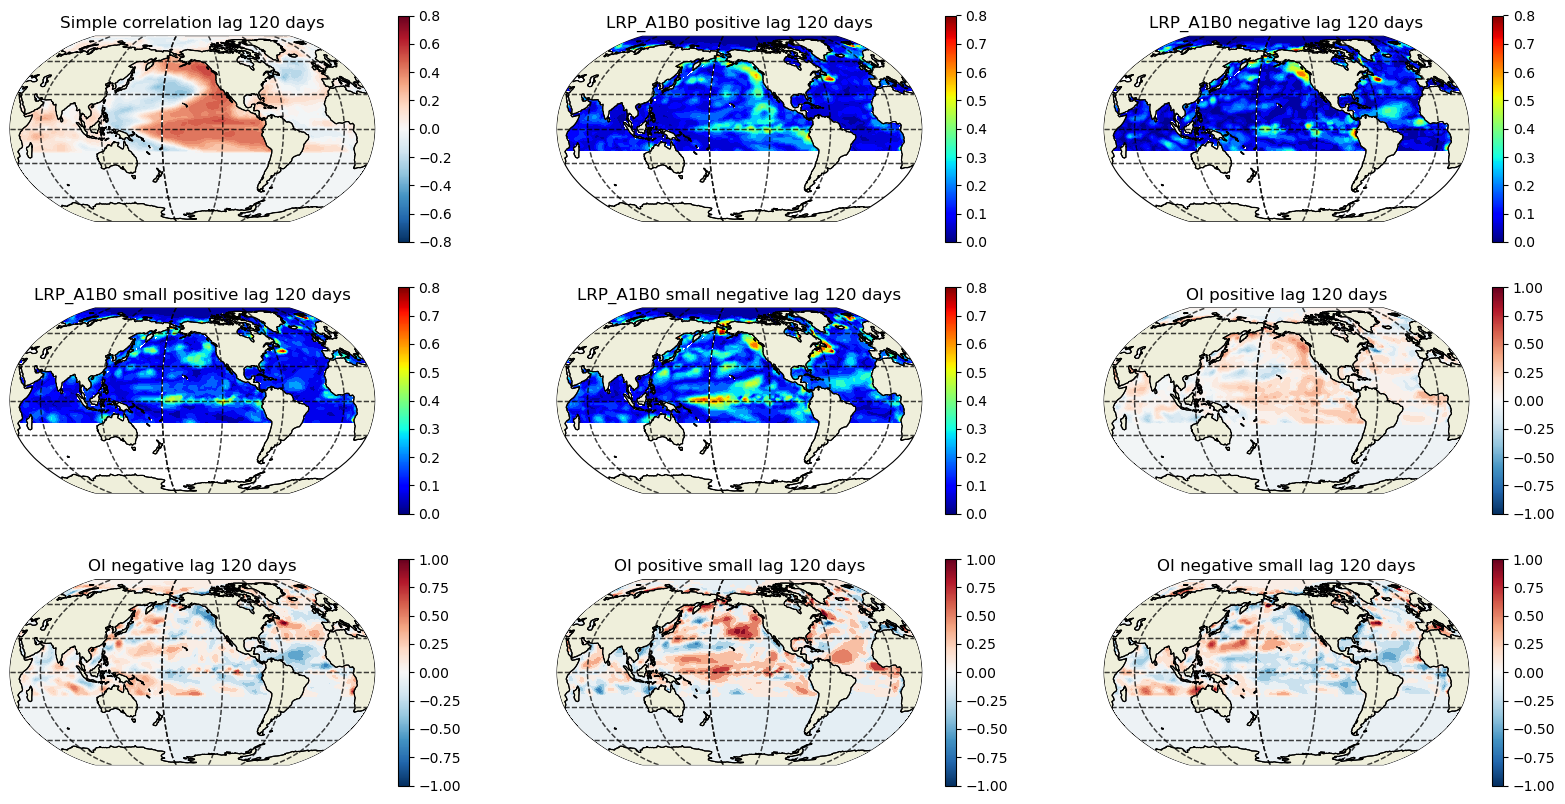

In [12]:
plt.rcParams["figure.figsize"] = (20,10)

lag = 120

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], corr_dict[lag],
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', 
                              cmin = -0.8, cmax = 0.8, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,1]);
P[1].set_title(f"Simple correlation lag {lag} days")

field = ds_LRP_A1B0[f'lrp_{lag}_a1b0_b_pos_all'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', 
                              cmin = 0, cmax = 0.8, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,2]);
P[1].set_title(f"LRP_A1B0 positive lag {lag} days")

field = ds_LRP_A1B0[f'lrp_{lag}_a1b0_b_neg_all'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', 
                              cmin = 0, cmax = 0.8, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,3]);
P[1].set_title(f"LRP_A1B0 negative lag {lag} days")

field = ds_LRP_A1B0_small[f'lrp_{lag}_a1b0_b_pos_all'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', 
                              cmin = 0, cmax = 0.8, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,4]);
P[1].set_title(f"LRP_A1B0 small positive lag {lag} days")

field = ds_LRP_A1B0_small[f'lrp_{lag}_a1b0_b_neg_all'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', 
                              cmin = 0, cmax = 0.8, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,5]);
P[1].set_title(f"LRP_A1B0 small negative lag {lag} days")

field = ds_OI_pos[f'OI_{lag}'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', 
                              cmin = -1, cmax = 1, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,6]);
P[1].set_title(f"OI positive lag {lag} days")

field = ds_OI_neg[f'OI_{lag}'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', 
                              cmin = -1, cmax = 1, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,7]);
P[1].set_title(f"OI negative lag {lag} days")

field = ds_OI_pos_small[f'OI_{lag}'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', 
                              cmin = -1, cmax = 1, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,8]);
P[1].set_title(f"OI positive small lag {lag} days")

field = ds_OI_neg_small[f'OI_{lag}'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', 
                              cmin = -1, cmax = 1, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,9]);
P[1].set_title(f"OI negative small lag {lag} days")

Text(0.5, 1.0, 'OI negative small lag 180 days')

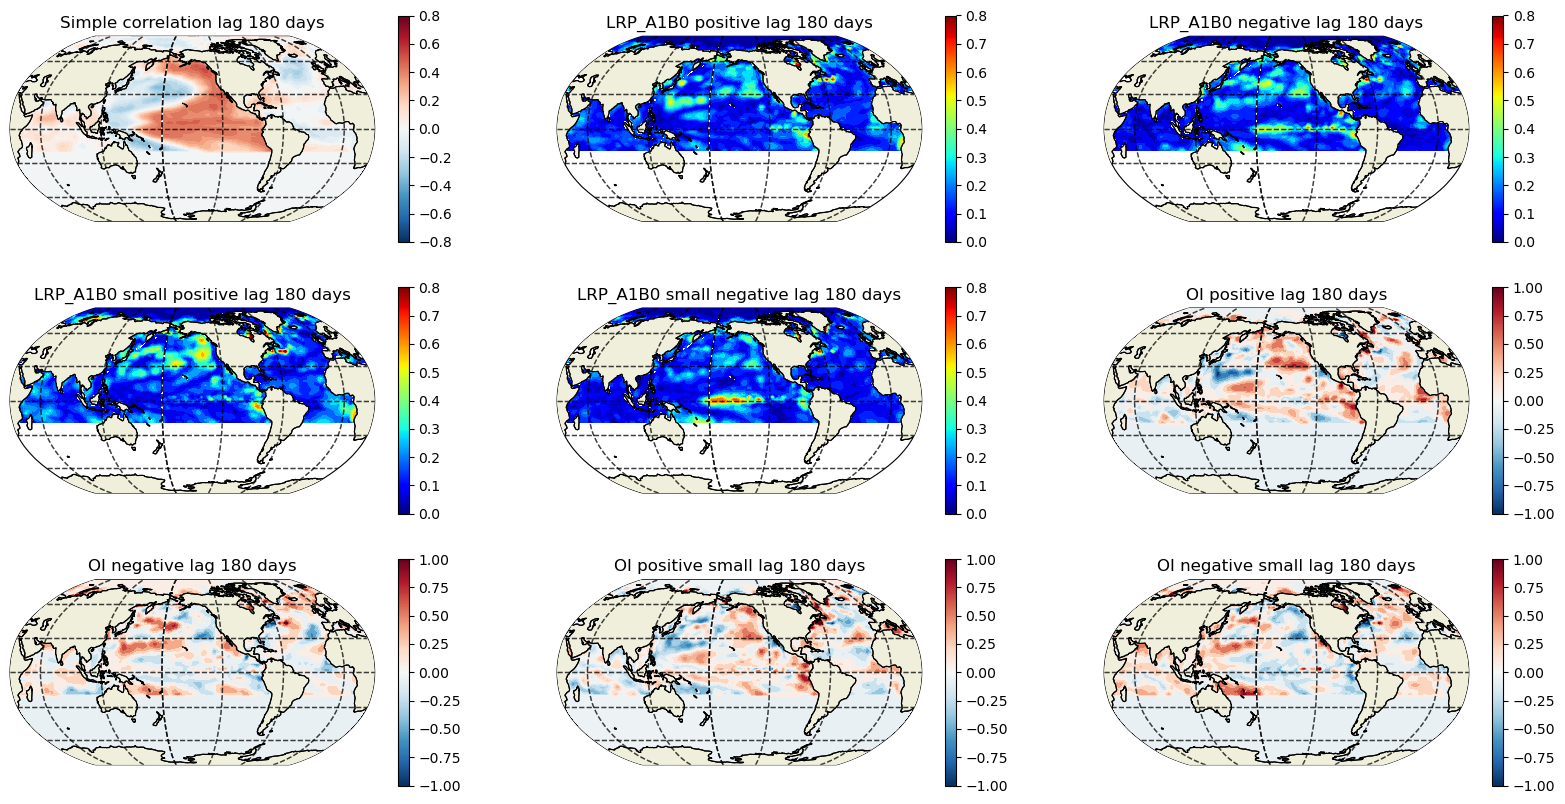

In [13]:
plt.rcParams["figure.figsize"] = (20,10)

lag = 180

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], corr_dict[lag],
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', 
                              cmin = -0.8, cmax = 0.8, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,1]);
P[1].set_title(f"Simple correlation lag {lag} days")

field = ds_LRP_A1B0[f'lrp_{lag}_a1b0_b_pos_all'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', 
                              cmin = 0, cmax = 0.8, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,2]);
P[1].set_title(f"LRP_A1B0 positive lag {lag} days")

field = ds_LRP_A1B0[f'lrp_{lag}_a1b0_b_neg_all'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', 
                              cmin = 0, cmax = 0.8, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,3]);
P[1].set_title(f"LRP_A1B0 negative lag {lag} days")

field = ds_LRP_A1B0_small[f'lrp_{lag}_a1b0_b_pos_all'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', 
                              cmin = 0, cmax = 0.8, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,4]);
P[1].set_title(f"LRP_A1B0 small positive lag {lag} days")

field = ds_LRP_A1B0_small[f'lrp_{lag}_a1b0_b_neg_all'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', 
                              cmin = 0, cmax = 0.8, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,5]);
P[1].set_title(f"LRP_A1B0 small negative lag {lag} days")

field = ds_OI_pos[f'OI_{lag}'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', 
                              cmin = -1, cmax = 1, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,6]);
P[1].set_title(f"OI positive lag {lag} days")

field = ds_OI_neg[f'OI_{lag}'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', 
                              cmin = -1, cmax = 1, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,7]);
P[1].set_title(f"OI negative lag {lag} days")

field = ds_OI_pos_small[f'OI_{lag}'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', 
                              cmin = -1, cmax = 1, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,8]);
P[1].set_title(f"OI positive small lag {lag} days")

field = ds_OI_neg_small[f'OI_{lag}'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', 
                              cmin = -1, cmax = 1, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,9]);
P[1].set_title(f"OI negative small lag {lag} days")

Text(0.5, 1.0, 'OI negative small lag minus60 days')

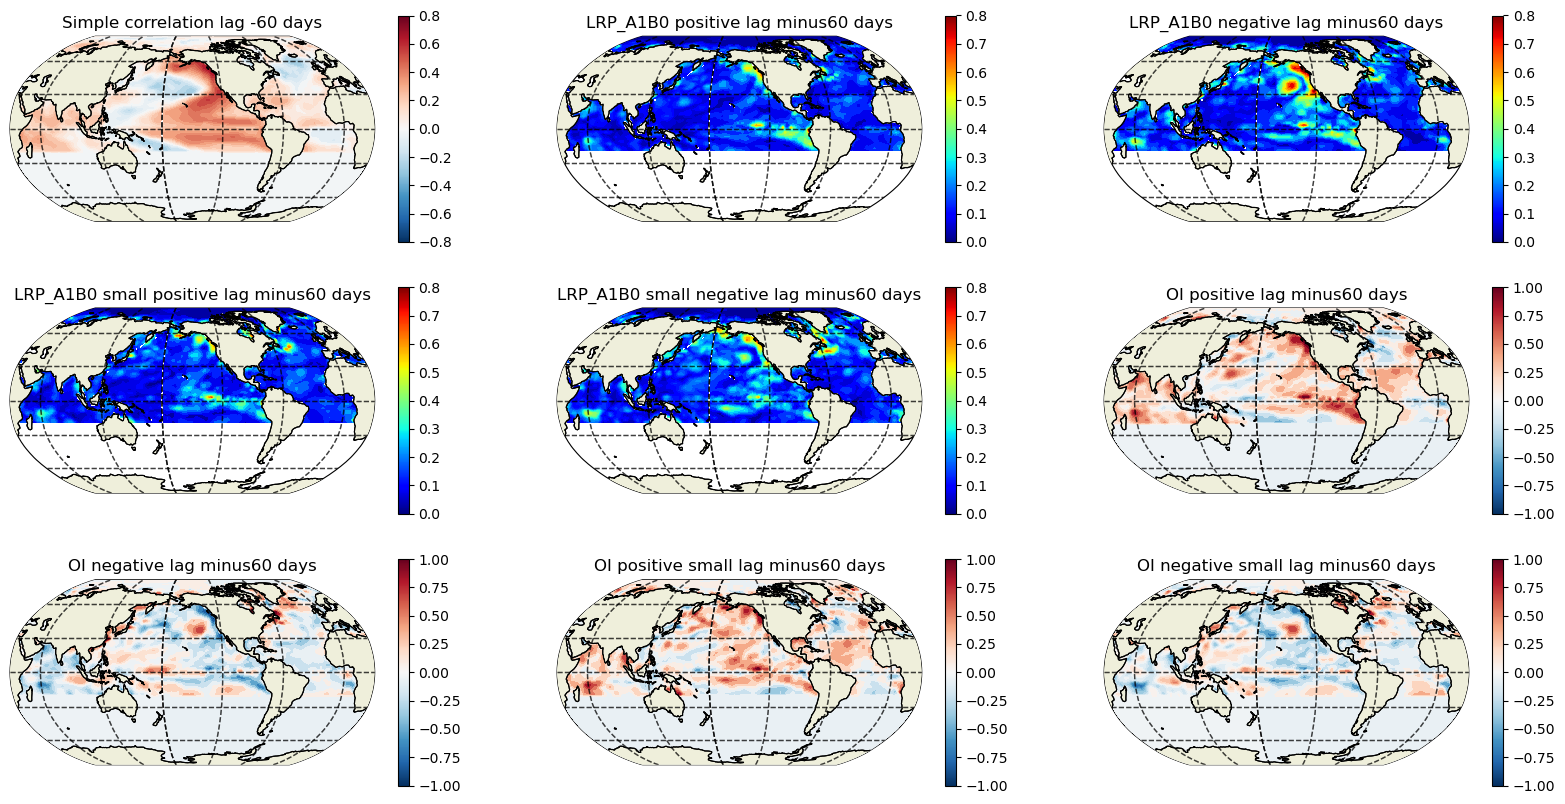

In [15]:
plt.rcParams["figure.figsize"] = (20,10)

lag = -60

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], corr_dict[lag],
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', 
                              cmin = -0.8, cmax = 0.8, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,1]);
P[1].set_title(f"Simple correlation lag {lag} days")

lag = 'minus60'
field = ds_LRP_A1B0[f'lrp_{lag}_a1b0_b_pos_all'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', 
                              cmin = 0, cmax = 0.8, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,2]);
P[1].set_title(f"LRP_A1B0 positive lag {lag} days")

field = ds_LRP_A1B0[f'lrp_{lag}_a1b0_b_neg_all'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', 
                              cmin = 0, cmax = 0.8, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,3]);
P[1].set_title(f"LRP_A1B0 negative lag {lag} days")

field = ds_LRP_A1B0_small[f'lrp_{lag}_a1b0_b_pos_all'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', 
                              cmin = 0, cmax = 0.8, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,4]);
P[1].set_title(f"LRP_A1B0 small positive lag {lag} days")

field = ds_LRP_A1B0_small[f'lrp_{lag}_a1b0_b_neg_all'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='jet', 
                              cmin = 0, cmax = 0.8, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,5]);
P[1].set_title(f"LRP_A1B0 small negative lag {lag} days")

field = ds_OI_pos[f'OI_{lag}'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', 
                              cmin = -1, cmax = 1, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,6]);
P[1].set_title(f"OI positive lag {lag} days")

field = ds_OI_neg[f'OI_{lag}'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', 
                              cmin = -1, cmax = 1, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,7]);
P[1].set_title(f"OI negative lag {lag} days")

field = ds_OI_pos_small[f'OI_{lag}'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', 
                              cmin = -1, cmax = 1, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,8]);
P[1].set_title(f"OI positive small lag {lag} days")

field = ds_OI_neg_small[f'OI_{lag}'].copy()

P = ecco.plot_proj_to_latlon_grid(ds['XC'], ds['YC'], field,
                              plot_type = 'contourf',
                              show_colorbar=True, cmap='RdBu_r', 
                              cmin = -1, cmax = 1, user_lon_0 = -150,
                              dx=2, dy=2, projection_type = 'robin',
                              less_output = True, subplot_grid = [3,3,9]);
P[1].set_title(f"OI negative small lag {lag} days")